**参考: https://github.com/lucidrains/med-seg-diff-pytorch/tree/main**

In [ ]:
import math
import copy
from random import random
from functools import partial
from collections import namedtuple
!pip install beartype
from beartype import beartype

import torch
from torch import nn, einsum
from torch.nn import Module, ModuleList
import torch.nn.functional as F
from torch.fft import fft2, ifft2

!pip install einops
from einops import rearrange, reduce
from einops.layers.torch import Rearrange

from tqdm.auto import tqdm

!pip install med_seg_diff_pytorch
from med_seg_diff_pytorch.med_seg_diff_pytorch import MedSegDiff, Unet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.1/866.1 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.3 MB/s eta 0:00:00


In [ ]:
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.cuda.amp as amp

from torch.utils.data import Dataset, DataLoader
!pip install segmentation_models_pytorch
import segmentation_models_pytorch as smp

import numpy as np
import pandas as pd
from tqdm import tqdm

import time
import copy
import random

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
pd.options.plotting.backend = "plotly" # pandasのデータをplotするときに使える
import cv2

import albumentations as A

from glob import glob
import os

from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.6 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=7225e711305164430d885e396ee19d54652ac002f028761310d21b4b51ab3e30
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=6cca07d053def3ad9e0b8573e2fa7142846881861f7b94905327c34336c4b876
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **ハイパーパラメータ**

In [ ]:
class CFG:
    seed          = 42
    debug         = False
    model_name    = 'Unet'
    train_bs      = 2
    valid_bs      = train_bs*2
    img_size      = (256,256)

    epochs        = 30
    lr            = 2e-3
    scheduler     = 'CosineAnnealingLR'
    min_lr        = 1e-6
    T_max         = int(30000/train_bs*epochs)+50
    T_0           = 25
    warmup_epochs = 0
    wd            = 1e-6
    n_accumulate  = max(1, 32//train_bs)
    n_fold        = 5
    fold_selected = 1
    num_classes   = 3
    device        = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## **データセット**

In [ ]:
data_root = "/content/drive/MyDrive/kaggle/lgg-mri-segmentation/kaggle_3m/"

In [ ]:
# ランレングスエンコード(RLE)形式でエンコードされたマスク情報をでコードする
# マスク領域を1、背景を0で表現するNumpy配列に変換
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    return: マスク領域を1、背景を0で表現するNumpy配列を返す

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

def rle_encode(img):
    '''
    img: マスク領域1,背景0のNumpy配列
    Returns: RLE形式の文字列
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [ ]:
def positiv_negativ_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : return 1
    else: return 0
def create_rle(mask_path):
    mask = cv2.imread(mask_path, cv2.IMREAD_ANYDEPTH)
    h = mask.shape[0]
    w = mask.shape[1]
    mask_rle = rle_encode(mask)
    return mask_rle



def create_df(data_root):
    """
    画像のpathリストを作成
    """
    img_list = []
    anno_list = []

    BEGIN_LEN    = 105
    END_IMG_LEN  = 4
    END_MASK_LEN = 9
    for sub_dir_path in os.listdir(data_root):
        sub_dir_path = os.path.join(data_root, sub_dir_path)
        if not os.path.isdir(sub_dir_path):
            continue
        for img_path in os.listdir(sub_dir_path):
            img_path = os.path.join(sub_dir_path, img_path)
            if img_path.endswith("_mask.tif"):
                anno_list.append(img_path)
            else:
                img_list.append(img_path)
    img_list  = sorted(img_list, key=lambda x : int(x[BEGIN_LEN:-END_IMG_LEN]))
    anno_list = sorted(anno_list, key=lambda x : int(x[BEGIN_LEN:-END_MASK_LEN]))

    df = pd.DataFrame(data={"img_path": img_list, "mask_path": anno_list})
    df["diagnosis"] = df["mask_path"].apply(lambda m: positiv_negativ_diagnosis(m))
    df["mask_rle"]  = df["mask_path"].apply(lambda m: create_rle(m))
    df["height"] = int(CFG.img_size[0])
    df["width"] = int(CFG.img_size[1])

    return df

print("データパスを作成しますか？(y/n)")
if input() == "y":
    df = create_df(data_root)
    df.to_csv(os.path.join(data_root, "df.csv"), index=False)
    print("データパスを作成しました。")
else:
    df = pd.read_csv(os.path.join(data_root, "df.csv"))
    df.fillna('',inplace=True)
    print("データパスを読み込みました。")
df.info()

データパスを作成しますか？(y/n)
n
データパスを読み込みました。
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   img_path   3929 non-null   object
 1   mask_path  3929 non-null   object
 2   diagnosis  3929 non-null   int64 
 3   mask_rle   3929 non-null   object
 4   height     3929 non-null   int64 
 5   width      3929 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 184.3+ KB


In [ ]:
skf = StratifiedGroupKFold(n_splits=CFG.n_fold, shuffle=True, random_state=42) # n_splitsでデータの分割数を指定


"""
X: 特徴量(説明変数)
y: 目的変数
"""
for fold, (_, val_idx) in enumerate(skf.split(X=df, y=df['diagnosis'],groups =df['diagnosis']), 1):
    df.loc[val_idx, 'fold'] = fold

df['fold'] = df['fold'].astype(np.uint8) # foldの値は初期設定で小数になってるので整数に変換
train_ids = df[df["fold"]!=CFG.fold_selected].index
valid_ids = df[df["fold"]==CFG.fold_selected].index
df.groupby('fold').size()

fold
1    2556
4    1373
dtype: int64

In [ ]:
class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms = transforms

    def __len__(self):
        return len(self.df)


    def __getitem__(self, index):
        # masks = np.zeros((CFG.img_size[0],CFG.img_size[1], 3), dtype=np.float32)
        masks = np.zeros((CFG.img_size[0],CFG.img_size[1], 1), dtype=np.float32)
        img_path=self.df['img_path'].iloc[index]
        w=self.df['width'].iloc[index]
        h=self.df['height'].iloc[index]

        img = self.__load_img(img_path)
        rle = df['mask_rle'].iloc[index]
        mask = rle_decode(rle,(h,w,1))
        mask = cv2.resize(mask,CFG.img_size)
        masks[:,:,0] = mask
        masks = masks.transpose(2, 0, 1)
        img = img.transpose(2, 0, 1)

        return torch.tensor(img), torch.tensor(masks)

    def __load_gray_img(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_ANYDEPTH)
        img = (img - img.min())/(img.max() - img.min())*255.0
        img = cv2.resize(img, CFG.img_size)
        img = np.expand_dims(img, axis=-1)
        img = img.astype(np.float32) / 255.
        return img
    def __load_img(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
        img = (img - img.min())/(img.max() - img.min())*255.0
        img = cv2.resize(img, CFG.img_size)
        # img = np.tile(img[...,None], [1, 1, 3]) # gray to rgb
        img = img.astype(np.float32) /255.
        return img

In [ ]:
data_transforms = {
    "train": A.Compose([
        A.Resize(*CFG.img_size, interpolation=cv2.INTER_NEAREST),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.OneOf([
                A.RandomBrightnessContrast(),
                A.RandomGamma(),
                A.RandomBrightness(),
                ], p=0.2),

        ], p=1.0),
    "valid": A.Compose([
        A.Resize(*CFG.img_size, interpolation=cv2.INTER_NEAREST),
        ], p=1.0)
}

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [ ]:
# train_dataset = BuildDataset(df, transforms=data_transforms['train'])
# valid_dataset = BuildDataset(df, transforms=data_transforms['valid'])
train_dataset = BuildDataset(df[df.index.isin(train_ids)], transforms=data_transforms['train'])
valid_dataset = BuildDataset(df[df.index.isin(valid_ids)], transforms=data_transforms['valid'])

train_loader = DataLoader(train_dataset, batch_size=CFG.train_bs, num_workers=4, shuffle=True, pin_memory=True, drop_last=False)
valid_loader = DataLoader(valid_dataset, batch_size=CFG.valid_bs,num_workers=4, shuffle=False, pin_memory=True)

# imgs, msks = next(iter(train_loader))
# imgs.size(), msks.size()

## **画像の表示**

In [ ]:
def plot_img_and_mask(imgs,masks,num=16):
    plt.figure(figsize=(16,16))
    for i in range(num):
        img = imgs[i].numpy().transpose(1,2,0)
        # mean = [0.485, 0.456, 0.406]
        # std = [0.229, 0.224, 0.225]

        # img = (img*std+mean).astype(np.float32)

        mask = masks[i][0].numpy().astype(np.float32)

        # 0から1の範囲に変換
        # img  = np.clip(img, 0, 1)
        # mask = np.clip(mask, 0,1)

        # img      = cv2.cvtColor(imgs[i].cpu().numpy(),cv2.COLOR_BGR2RGB)
        # mask = masks[i,:,:].cpu().numpy()
        plt.subplot(1,num,i+1)
        plt.imshow(img)
        plt.imshow(mask,alpha=0.7)
        plt.axis("off")
    plt.show()


## **損失関数の定義**

In [ ]:
DiceLoss    = smp.losses.DiceLoss(mode='multilabel')
BCELoss     = smp.losses.SoftBCEWithLogitsLoss()

def dice_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon)).mean(dim=(1,0))
    return dice

def iou_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    union = (y_true + y_pred - y_true*y_pred).sum(dim=dim)
    iou = ((inter+epsilon)/(union+epsilon)).mean(dim=(1,0))
    return iou

def criterion(y_pred, y_true):
    return 0.6*BCELoss(y_pred, y_true) + 0.4*DiceLoss(y_pred, y_true)

## **モデルの定義**

In [ ]:
ModelPrediction =  namedtuple('ModelPrediction', ['pred_noise', 'pred_x_start'])

In [ ]:
def identity(t, *args, **kwargs):
    return t

In [ ]:
def exists(x):
    return x is not None

In [ ]:
def default(val, d):
    if exists(val):
        return val
    return d() if callable(d) else d

### **Linear Attetnion**
**参考:** https://arxiv.org/pdf/2006.16236.pdf \
Attentino機構の計算量を早くしたもの?


In [ ]:
class LinearAttention(Module):
    def __init__(self, dim, heads = 4, dim_head = 32):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        hidden_dim = dim_head * heads

        self.prenorm = LayerNorm(dim)
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias = False)

        self.to_out = nn.Sequential(
            nn.Conv2d(hidden_dim, dim, 1),
            LayerNorm(dim)
        )

    def forward(self, x):
        b, c, h, w = x.shape

        x = self.prenorm(x)

        qkv = self.to_qkv(x).chunk(3, dim = 1)
        q, k, v = map(lambda t: rearrange(t, 'b (h c) x y -> b h c (x y)', h = self.heads), qkv)

        q = q.softmax(dim = -2)
        k = k.softmax(dim = -1)

        q = q * self.scale

        context = torch.einsum('b h d n, b h e n -> b h d e', k, v)

        out = torch.einsum('b h d e, b h d n -> b h e n', context, q)
        out = rearrange(out, 'b h c (x y) -> b (h c) x y', h = self.heads, x = h, y = w)
        return self.to_out(out)


### **Resnet**

In [ ]:
class Block(Module):
    def __init__(self, dim, dim_out, groups = 8):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, padding = 1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x

In [ ]:
class ResnetBlock(Module):
    def __init__(self, dim, dim_out, *, time_emb_dim = None, groups = 8):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, dim_out * 2)
        ) if exists(time_emb_dim) else None

        self.block1 = Block(dim, dim_out, groups = groups)
        self.block2 = Block(dim_out, dim_out, groups = groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb = None):

        scale_shift = None
        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            time_emb = rearrange(time_emb, 'b c -> b c 1 1')
            scale_shift = time_emb.chunk(2, dim = 1)

        h = self.block1(x, scale_shift = scale_shift)

        h = self.block2(h)

        return h + self.res_conv(x)

### **ViT**

In [ ]:
class LayerNorm(Module):
    def __init__(self, dim, bias = False):
        super().__init__()
        self.g = nn.Parameter(torch.ones(1, dim, 1, 1))
        self.b = nn.Parameter(torch.zeros(1, dim, 1, 1)) if bias else None

    def forward(self, x):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3
        var = torch.var(x, dim = 1, unbiased = False, keepdim = True)
        mean = torch.mean(x, dim = 1, keepdim = True)
        return (x - mean) * (var + eps).rsqrt() * self.g + default(self.b, 0)


In [ ]:
class Residual(Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

In [ ]:
def FeedForward(dim, mult = 4):
    inner_dim = int(dim * mult)
    return nn.Sequential(
        LayerNorm(dim),
        nn.Conv2d(dim, inner_dim, 1),
        nn.GELU(),
        nn.Conv2d(inner_dim, dim, 1),
    )

In [ ]:
class Attention(Module):
    def __init__(self, dim, heads = 4, dim_head = 32):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        hidden_dim = dim_head * heads

        self.prenorm = LayerNorm(dim)
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias = False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape

        x = self.prenorm(x)

        qkv = self.to_qkv(x).chunk(3, dim = 1)
        q, k, v = map(lambda t: rearrange(t, 'b (h c) x y -> b h c (x y)', h = self.heads), qkv)

        q = q * self.scale

        sim = einsum('b h d i, b h d j -> b h i j', q, k)
        attn = sim.softmax(dim = -1)
        out = einsum('b h i j, b h d j -> b h i d', attn, v)

        out = rearrange(out, 'b h (x y) d -> b (h d) x y', x = h, y = w)
        return self.to_out(out)

In [ ]:
class Transformer(Module):
    def __init__(
        self,
        dim,
        dim_head = 32,
        heads = 4,
        depth = 1
    ):
        super().__init__()
        self.layers = ModuleList([])
        for _ in range(depth):
            self.layers.append(ModuleList([
                Residual(Attention(dim, dim_head = dim_head, heads = heads)),
                Residual(FeedForward(dim))
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x)
            x = ff(x)
        return x


In [ ]:
class ViT(Module):
    def __init__(
        self,dim,*,image_size,patch_size,channels = 3,channels_out = None,dim_head = 32,heads = 4,depth = 4):
        super().__init__()
        assert exists(image_size)
        assert (image_size % patch_size) == 0

        num_patches_height_width = image_size // patch_size

        self.pos_emb = nn.Parameter(torch.zeros(dim, num_patches_height_width, num_patches_height_width))

        channels_out = default(channels_out, channels)

        patch_dim = channels * (patch_size ** 2)
        output_patch_dim = channels_out * (patch_size ** 2)

        self.to_tokens = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (c p1 p2) h w', p1 = patch_size, p2 = patch_size),
            nn.Conv2d(patch_dim, dim, 1),
            LayerNorm(dim)
        )

        self.transformer = Transformer(
            dim = dim,
            dim_head = dim_head,
            depth = depth
        )

        self.to_patches = nn.Sequential(
            LayerNorm(dim),
            nn.Conv2d(dim, output_patch_dim, 1),
            Rearrange('b (c p1 p2) h w -> b c (h p1) (w p2)', p1 = patch_size, p2 = patch_size),
        )

        nn.init.zeros_(self.to_patches[-2].weight)
        nn.init.zeros_(self.to_patches[-2].bias)

    def forward(self, x):
        x = self.to_tokens(x)
        x = x + self.pos_emb

        x = self.transformer(x)
        return self.to_patches(x)


In [ ]:
# prompt: ViTの動作確認

vit = ViT(dim = 128, channels = 3, channels_out = 3, image_size = 256, patch_size = 16, heads = 4, dim_head = 32, depth = 4)

x = torch.randn(1, 3, 256, 256)
y = vit(x)

print(y.shape)


torch.Size([1, 3, 256, 256])


### **正弦波エンコーディング**

In [ ]:
class SinusoidalPosEmb(Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

In [ ]:
def _pos_encoding(t,D):
    """
    t: 位置情報
    D: 次元数
    """
    device = t.device
    v = torch.zeros(D).to(device)    # [0, 0, ..., 0]
    i = torch.arange(0,D).to(device) # [0, 1, ..., D]

    # v[0::2]: 0, 2, 4, ... (0始まりの偶数)
    # v[1::2]: 1, 3, 5, ... (1始まりの奇数)
    div_term = torch.exp(i/D * math.log(10000))

    v[0::2] = torch.sin(t / div_term[0::2])
    v[1::2] = torch.cos(t / div_term[1::2])
    return v

def pos_encoding(timesteps,outputs_dim):
    """
    timesteps: ノイズにするまでのステップ回数
    outputs_dim: 出力の次元数
    """
    device = timesteps.device
    batch_size = timesteps.shape[0]
    v = torch.zeros(batch_size,outputs_dim).to(device)
    for i in range(batch_size):
        v[i] = _pos_encoding(timesteps[i],outputs_dim)
    return v

In [ ]:
class TimeEmbedding(Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.D = in_ch
        self.mlp = nn.Sequential(
            nn.Linear(in_ch, out_ch),
            nn.GELU(),
            nn.Linear(out_ch, out_ch)
        )
    def forward(self, t):
        v = pos_encoding(t, self.D) # channel数をin_chに変換
        v = self.mlp(v)
        return v

In [ ]:
# 動作確認
test = TimeEmbedding(in_ch=64, out_ch=256)
a = test(torch.tensor([1,2,3,4,5])).shape

### **条件付け**

In [ ]:
class Conditioning(Module):
    def __init__(self,fmap_size,dim,dynamic=True,image_size=None,dim_head=32,heads=4,depth=4,patch_size=16):
        super().__init__()
        self.ff_parser_attn_map = nn.Parameter(torch.randn(dim,fmap_size,fmap_size)) # FFT後に加算する学習可能パラメータ
        self.dynamic = dynamic
        if dynamic:
            self.to_dynamic_ff_parser_attn_map = ViT(
                dim = dim,
                channels = dim * 2 * 2,
                channels_out = dim,
                image_size = image_size,
                patch_size = patch_size,
                heads = heads,
                dim_head = dim_head
            )
        self.LN_x = LayerNorm(dim,bias=True)
        self.LN_c = LayerNorm(dim,bias=True)
        self.block = ResnetBlock(dim,dim)
    def forward(self,x,c):
        ff_parser_attn_map = self.ff_parser_attn_map
        dtype = x.dtype
        x = fft2(x) # 2次元離散フーリエ変換を実行

        if self.dynamic:
            c_complex = fft2(c)
            x_as_real, c_as_real = map(torch.view_as_real, (x, c_complex))
            x_as_real, c_as_real = map(lambda t: rearrange(t, 'b d h w ri -> b (d ri) h w'), (x_as_real, c_as_real))

            to_dynamic_input = torch.cat((x_as_real, c_as_real), dim = 1)

            dynamic_ff_parser_attn_map = self.to_dynamic_ff_parser_attn_map(to_dynamic_input)

            ff_parser_attn_map = ff_parser_attn_map + dynamic_ff_parser_attn_map # 動的な場合,FFT後に加算する学習可能パラメータ
        x = x * ff_parser_attn_map
        x = ifft2(x)
        x = x.type(dtype)

        norm_x = self.LN_x(x)
        norm_c = self.LN_c(c)
        c = (norm_x * norm_c) * c
        return self.block(c) # ResNetBlockで畳み込み


In [ ]:
# prompt: 動作確認

cond = Conditioning(fmap_size=16, dim=64, image_size=16)
x = torch.randn(1, 64, 16, 16)
c = torch.randn(1, 64, 16, 16)
y = cond(x, c)
print(y.shape)


torch.Size([1, 64, 16, 16])


<ipython-input-31-347122f3dc12>:36: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:299.)
  x = x.type(dtype)


### **U-Net**

In [ ]:
def Upsample(dim, dim_out = None):
    return nn.Sequential(
        nn.Upsample(scale_factor = 2, mode = 'nearest'),
        nn.Conv2d(dim, default(dim_out, dim), 3, padding = 1)
    )

def Downsample(dim, dim_out = None):
    return nn.Sequential(
        Rearrange('b c (h p1) (w p2) -> b (c p1 p2) h w', p1 = 2, p2 = 2),
        nn.Conv2d(dim * 4, default(dim_out, dim), 1)
    )

In [ ]:
@beartype
class Unet(Module):
    def __init__(
        self,
        dim,
        image_size,
        mask_channels = 1,
        input_img_channels = 3,
        init_dim = None,
        out_dim = None,
        dim_mults: tuple = (1, 2, 4, 8),
        full_self_attn: tuple = (False, False, False, True),
        attn_dim_head = 32,
        attn_heads = 4,
        mid_transformer_depth = 1,
        self_condition = False,
        resnet_block_groups = 8,
        conditioning_klass = Conditioning,
        skip_connect_condition_fmaps = False,    # whether to concatenate the conditioning fmaps in the latter decoder upsampling portion of unet
        dynamic_ff_parser_attn_map = False,      # allow for ff-parser to be dynamic based on the input. will exclude condition for now
        conditioning_kwargs: dict = dict(
            dim_head = 32,
            heads = 4,
            depth = 4,
            patch_size = 16
        )
    ):
        super().__init__()

        self.image_size = image_size

        # 入力層
        self.input_img_channels = input_img_channels
        self.mask_channels = mask_channels
        self.self_condition = self_condition

        output_channels = mask_channels
        mask_channels = mask_channels * (2 if self_condition else 1)

        init_dim = default(init_dim, dim)
        self.init_conv = nn.Conv2d(mask_channels, init_dim, 7, padding = 3)
        self.cond_init_conv = nn.Conv2d(input_img_channels, init_dim, 7, padding = 3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        block_klass = partial(ResnetBlock, groups = resnet_block_groups)

        # 位置符号化で時間をトークンに変える
        time_dim = dim * 4

        # self.time_mlp = TimeEmbedding(dim, time_dim)
        self.time_mlp = nn.Sequential(
            SinusoidalPosEmb(dim),
            nn.Linear(dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim)
        )

        # attention related params

        attn_kwargs = dict(
            dim_head = attn_dim_head,
            heads = attn_heads
        )

        # conditioner settings

        if conditioning_klass == Conditioning:
            conditioning_klass = partial(
                Conditioning,
                dynamic = dynamic_ff_parser_attn_map,
                **conditioning_kwargs
            )

        # layers

        num_resolutions = len(in_out)
        assert len(full_self_attn) == num_resolutions

        self.conditioners = ModuleList([])

        self.skip_connect_condition_fmaps = skip_connect_condition_fmaps

        # downsampling encoding blocks

        self.downs = ModuleList([])

        curr_fmap_size = image_size

        for ind, ((dim_in, dim_out), full_attn) in enumerate(zip(in_out, full_self_attn)):
            is_last = ind >= (num_resolutions - 1)
            attn_klass = Attention if full_attn else LinearAttention

            self.conditioners.append(conditioning_klass(curr_fmap_size, dim_in, image_size = curr_fmap_size))

            self.downs.append(ModuleList([
                block_klass(dim_in, dim_in, time_emb_dim = time_dim),
                block_klass(dim_in, dim_in, time_emb_dim = time_dim),
                Residual(attn_klass(dim_in, **attn_kwargs)),
                Downsample(dim_in, dim_out) if not is_last else nn.Conv2d(dim_in, dim_out, 3, padding = 1)
            ]))

            if not is_last:
                curr_fmap_size //= 2

        # middle blocks

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim = time_dim)
        self.mid_transformer = Transformer(mid_dim, depth = mid_transformer_depth, **attn_kwargs)
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim = time_dim)

        # condition encoding path will be the same as the main encoding path

        self.cond_downs = copy.deepcopy(self.downs)
        self.cond_mid_block1 = copy.deepcopy(self.mid_block1)

        # upsampling decoding blocks

        self.ups = ModuleList([])

        for ind, ((dim_in, dim_out), full_attn) in enumerate(zip(reversed(in_out), reversed(full_self_attn))):
            is_last = ind == (len(in_out) - 1)
            attn_klass = Attention if full_attn else LinearAttention

            skip_connect_dim = dim_in * (2 if self.skip_connect_condition_fmaps else 1)

            self.ups.append(ModuleList([
                block_klass(dim_out + skip_connect_dim, dim_out, time_emb_dim = time_dim),
                block_klass(dim_out + skip_connect_dim, dim_out, time_emb_dim = time_dim),
                Residual(attn_klass(dim_out, **attn_kwargs)),
                Upsample(dim_out, dim_in) if not is_last else  nn.Conv2d(dim_out, dim_in, 3, padding = 1)
            ]))

        # projection out to predictions

        self.final_res_block = block_klass(dim * 2, dim, time_emb_dim = time_dim)
        self.final_conv = nn.Conv2d(dim, output_channels, 1)

    def forward(
        self,
        x,
        time,
        cond,
        x_self_cond = None
    ):
        dtype, skip_connect_c = x.dtype, self.skip_connect_condition_fmaps

        if self.self_condition:
            x_self_cond = default(x_self_cond, lambda: torch.zeros_like(x))
            x = torch.cat((x_self_cond, x), dim = 1)

        x = self.init_conv(x)
        r = x.clone()

        c = self.cond_init_conv(cond)

        t = self.time_mlp(time)

        h = []

        for (block1, block2, attn, downsample), (cond_block1, cond_block2, cond_attn, cond_downsample), conditioner in zip(self.downs, self.cond_downs, self.conditioners):
            x = block1(x, t)
            c = cond_block1(c, t)

            h.append([x, c] if skip_connect_c else [x])

            x = block2(x, t)
            c = cond_block2(c, t)

            x = attn(x)
            c = cond_attn(c)

            # condition using modulation of fourier frequencies with attentive map
            # you can test your own conditioners by passing in a different conditioner_klass , if you believe you can best the paper

            c = conditioner(x, c)

            h.append([x, c] if skip_connect_c else [x])

            x = downsample(x)
            c = cond_downsample(c)

        x = self.mid_block1(x, t)
        c = self.cond_mid_block1(c, t)

        x = x + c  # seems like they summed the encoded condition to the encoded input representation

        x = self.mid_transformer(x)
        x = self.mid_block2(x, t)

        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, *h.pop()), dim = 1)
            x = block1(x, t)

            x = torch.cat((x, *h.pop()), dim = 1)
            x = block2(x, t)
            x = attn(x)

            x = upsample(x)

        x = torch.cat((x, r), dim = 1)

        x = self.final_res_block(x, t)
        return self.final_conv(x)

In [ ]:
# prompt: 動作確認

# unet = Unet(
#         dim = 128,
#         image_size = 256,
#         mask_channels = 1,
#         input_img_channels = 3,
#         init_dim = 128,
#         out_dim = 128,
#         dim_mults = (1, 2, 4, 8),
#         full_self_attn = (False, False, False, True),
#         attn_dim_head = 32,
#         attn_heads = 4,
#         mid_transformer_depth = 1,
#         self_condition = False,
#         resnet_block_groups = 8,
#         conditioning_klass = Conditioning,
#         skip_connect_condition_fmaps = False,    # whether to concatenate the conditioning fmaps in the latter decoder upsampling portion of unet
#         dynamic_ff_parser_attn_map = False,      # allow for ff-parser to be dynamic based on the input. will exclude condition for now
#         conditioning_kwargs = dict(
#             dim_head = 32,
#             heads = 4,
#             depth = 4,
#             patch_size = 16
#         )
#     )

# x = torch.randn(3, 1, 256, 256)
# c = torch.randn(3, 3, 256, 256)
# time = torch.randn(1)
# y = unet(x, time, c)
# print(y.shape)


#### 作成途中:

In [ ]:
# class Unet(Module):
#     """
#     img_size: 画像のサイズ
#     n_channels: 中間層でのチャンネル数
#     input_img_channels: 入力画像のチャンネル数
#     mask_channels: マスクのチャンネル数
#     """
#     def __init__(self,img_size,n_channels,input_img_channels=3,mask_channels=1):
#         super().__init__()
#         self.img_size          = img_size
#         self.input_img_channels = input_img_channels
#         self.mask_channels      = mask_channels
#         output_channels = mask_channels


#         self.init_conv = nn.Conv2d(mask_channels,n_channels,kernel_size=7,padding=3)
#         self.cond_init_conv = nn.Conv2d(input_img_channels,n_channels,kernel_size=7,padding=3)
#         self.time_embedding = TimeEmbedding(n_channels,n_channels*4)


#         self.downs = nn.ModuleList([])
#         self.cond_downs = nn.ModuleList([])
#         self.conditioners = nn.ModuleList([])

#     def forward(self,x,time,cond,x_self_cond=None):
#         # dtype, skip_connect_c = x.dtype, self.skip_connect_condition_fmap
#         x = self.init_conv(x)
#         r = x.clone()
#         c = self.cond_init_conv(cond)
#         t = self.time_embedding(time)
#         h = []

#         # self.downs, self.cond_downs, self.conditioners

#         return t

### **MedSegDiff**

In [ ]:
def extract(a, t, x_shape):
    b, *_ = t.shape
    out = a.gather(-1, t)
    return out.reshape(b, *((1,) * (len(x_shape) - 1)))

def linear_beta_schedule(timesteps):
    scale = 1000 / timesteps
    beta_start = scale * 0.0001
    beta_end = scale * 0.02
    return torch.linspace(beta_start, beta_end, timesteps, dtype = torch.float64)

def cosine_beta_schedule(timesteps, s = 0.008):
    """
    cosine schedule
    as proposed in https://openreview.net/forum?id=-NEXDKk8gZ
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps, dtype = torch.float64)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0, 0.999)

def normalize_to_neg_one_to_one(img):
    return img * 2 - 1

def unnormalize_to_zero_to_one(t):
    return (t + 1) * 0.5

In [1]:
class MedSegDiff(Module):
    """
    model: U-Net
    img: マスク画像
    cond_img: 元画像
    """
    def __init__(
        self,
        model,
        *,
        timesteps = 1000,
        sampling_timesteps = None,
        objective = 'pred_noise',
        beta_schedule = 'cosine',
        ddim_sampling_eta = 1.
    ):
        super().__init__()

        self.model = model if isinstance(model, Unet) else model.module

        self.input_img_channels = self.model.input_img_channels
        self.mask_channels = self.model.mask_channels
        self.self_condition = self.model.self_condition
        self.image_size = self.model.image_size

        self.objective = objective

        assert objective in {'pred_noise', 'pred_x0', 'pred_v'}, 'objective must be either pred_noise (predict noise) or pred_x0 (predict image start) or pred_v (predict v [v-parameterization as defined in appendix D of progressive distillation paper, used in imagen-video successfully])'

        if beta_schedule == 'linear':
            betas = linear_beta_schedule(timesteps)
        elif beta_schedule == 'cosine':
            betas = cosine_beta_schedule(timesteps)
        else:
            raise ValueError(f'unknown beta schedule {beta_schedule}')

        alphas = 1. - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)
        alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value = 1.)

        timesteps, = betas.shape
        self.num_timesteps = int(timesteps)

        # sampling related parameters

        self.sampling_timesteps = default(sampling_timesteps, timesteps) # default num sampling timesteps to number of timesteps at training

        assert self.sampling_timesteps <= timesteps
        self.is_ddim_sampling = self.sampling_timesteps < timesteps
        self.ddim_sampling_eta = ddim_sampling_eta

        # helper function to register buffer from float64 to float32

        register_buffer = lambda name, val: self.register_buffer(name, val.to(torch.float32))

        register_buffer('betas', betas)
        register_buffer('alphas_cumprod', alphas_cumprod)
        register_buffer('alphas_cumprod_prev', alphas_cumprod_prev)

        # calculations for diffusion q(x_t | x_{t-1}) and others

        register_buffer('sqrt_alphas_cumprod', torch.sqrt(alphas_cumprod))
        register_buffer('sqrt_one_minus_alphas_cumprod', torch.sqrt(1. - alphas_cumprod))
        register_buffer('log_one_minus_alphas_cumprod', torch.log(1. - alphas_cumprod))
        register_buffer('sqrt_recip_alphas_cumprod', torch.sqrt(1. / alphas_cumprod))
        register_buffer('sqrt_recipm1_alphas_cumprod', torch.sqrt(1. / alphas_cumprod - 1))

        # calculations for posterior q(x_{t-1} | x_t, x_0)

        posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

        # above: equal to 1. / (1. / (1. - alpha_cumprod_tm1) + alpha_t / beta_t)

        register_buffer('posterior_variance', posterior_variance)

        # below: log calculation clipped because the posterior variance is 0 at the beginning of the diffusion chain

        register_buffer('posterior_log_variance_clipped', torch.log(posterior_variance.clamp(min =1e-20)))
        register_buffer('posterior_mean_coef1', betas * torch.sqrt(alphas_cumprod_prev) / (1. - alphas_cumprod))
        register_buffer('posterior_mean_coef2', (1. - alphas_cumprod_prev) * torch.sqrt(alphas) / (1. - alphas_cumprod))

    @property
    def device(self):
        return next(self.parameters()).device

    def predict_start_from_noise(self, x_t, t, noise):
        return (
            extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t -
            extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * noise
        )

    def predict_noise_from_start(self, x_t, t, x0):
        return (
            (extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t - x0) / \
            extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape)
        )

    def predict_v(self, x_start, t, noise):
        return (
            extract(self.sqrt_alphas_cumprod, t, x_start.shape) * noise -
            extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape) * x_start
        )

    def predict_start_from_v(self, x_t, t, v):
        return (
            extract(self.sqrt_alphas_cumprod, t, x_t.shape) * x_t -
            extract(self.sqrt_one_minus_alphas_cumprod, t, x_t.shape) * v
        )

    def q_posterior(self, x_start, x_t, t):
        posterior_mean = (
            extract(self.posterior_mean_coef1, t, x_t.shape) * x_start +
            extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_variance = extract(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = extract(self.posterior_log_variance_clipped, t, x_t.shape)
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def model_predictions(self, x, t, c, x_self_cond = None, clip_x_start = False):
        model_output = self.model(x, t, c, x_self_cond)
        maybe_clip = partial(torch.clamp, min = -1., max = 1.) if clip_x_start else identity

        if self.objective == 'pred_noise':
            pred_noise = model_output
            x_start = self.predict_start_from_noise(x, t, pred_noise)
            x_start = maybe_clip(x_start)

        return ModelPrediction(pred_noise, x_start)

    def p_mean_variance(self, x, t, c, x_self_cond = None, clip_denoised = True):
        preds = self.model_predictions(x, t, c, x_self_cond)
        x_start = preds.pred_x_start

        if clip_denoised:
            x_start.clamp_(-1., 1.)

        model_mean, posterior_variance, posterior_log_variance = self.q_posterior(x_start = x_start, x_t = x, t = t)
        return model_mean, posterior_variance, posterior_log_variance, x_start

    @torch.no_grad()
    def p_sample(self, x, t, c, x_self_cond = None, clip_denoised = True):
        b, *_, device = *x.shape, x.device
        batched_times = torch.full((x.shape[0],), t, device = x.device, dtype = torch.long)
        model_mean, _, model_log_variance, x_start = self.p_mean_variance(x = x, t = batched_times, c = c, x_self_cond = x_self_cond, clip_denoised = clip_denoised)
        noise = torch.randn_like(x) if t > 0 else 0. # no noise if t == 0
        pred_img = model_mean + (0.5 * model_log_variance).exp() * noise
        return pred_img, x_start

    @torch.no_grad()
    def p_sample_loop(self, shape, cond):
        batch, device = shape[0], self.betas.device

        img = torch.randn(shape, device = device)

        x_start = None

        for t in tqdm(reversed(range(0, self.num_timesteps)), desc = 'sampling loop time step', total = self.num_timesteps):
            self_cond = x_start if self.self_condition else None
            img, x_start = self.p_sample(img, t, cond, self_cond)

        img = unnormalize_to_zero_to_one(img)
        return img

    @torch.no_grad()
    def ddim_sample(self, shape, cond_img, clip_denoised = True):
        batch, device, total_timesteps, sampling_timesteps, eta, objective = shape[0], self.betas.device, self.num_timesteps, self.sampling_timesteps, self.ddim_sampling_eta, self.objective

        times = torch.linspace(-1, total_timesteps - 1, steps=sampling_timesteps + 1)   # [-1, 0, 1, 2, ..., T-1] when sampling_timesteps == total_timesteps
        times = list(reversed(times.int().tolist()))
        time_pairs = list(zip(times[:-1], times[1:])) # [(T-1, T-2), (T-2, T-3), ..., (1, 0), (0, -1)]

        img = torch.randn(shape, device = device)

        x_start = None

        for time, time_next in tqdm(time_pairs, desc = 'sampling loop time step'):
            time_cond = torch.full((batch,), time, device=device, dtype=torch.long)
            self_cond = x_start if self.self_condition else None
            pred_noise, x_start, *_ = self.model_predictions(img, time_cond, cond_img, self_cond, clip_x_start = clip_denoised)

            if time_next < 0:
                img = x_start
                continue

            alpha = self.alphas_cumprod[time]
            alpha_next = self.alphas_cumprod[time_next]

            sigma = eta * ((1 - alpha / alpha_next) * (1 - alpha_next) / (1 - alpha)).sqrt()
            c = (1 - alpha_next - sigma ** 2).sqrt()

            noise = torch.randn_like(img)

            img = x_start * alpha_next.sqrt() + \
                  c * pred_noise + \
                  sigma * noise

        img = unnormalize_to_zero_to_one(img)
        return img

    @torch.no_grad()
    def sample(self, cond_img):
        batch_size, device = cond_img.shape[0], self.device
        cond_img = cond_img.to(self.device)

        image_size, mask_channels = self.image_size, self.mask_channels
        sample_fn = self.p_sample_loop if not self.is_ddim_sampling else self.ddim_sample
        return sample_fn((batch_size, mask_channels, image_size, image_size), cond_img)

    # q(x_t|x_0)のサンプリング
    def q_sample(self, x_start, t, noise=None):
        noise = default(noise, lambda: torch.randn_like(x_start))

         # x_t = sqrt(bar(α_t))*x_0 + sqrt(1-bar(α_t)*ε
        return (
            extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start +
            extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape) * noise
        )

    def p_losses(self, x_start, t, cond, noise = None):
        b, c, h, w = x_start.shape
        noise = default(noise, lambda: torch.randn_like(x_start))

        # q(x_t|x_0) : x_0からx_tをサンプリング
        x = self.q_sample(x_start = x_start, t = t, noise = noise)


        x_self_cond = None
        if self.self_condition and random() < 0.5:
            with torch.no_grad():

                # predicting x_0


                x_self_cond = self.model_predictions(x, t, cond).pred_x_start
                x_self_cond.detach_()

        # predict and take gradient step

        model_out = self.model(x, t, cond, x_self_cond)
        # print("")
        # print("出力します.")
        # print(model_out.shape)
        # print("---------------------")
        # 追加
        return model_out

        # if self.objective == 'pred_noise':
        #     target = noise
        # elif self.objective == 'pred_x0':
        #     target = x_start
        # elif self.objective == 'pred_v':
        #     v = self.predict_v(x_start, t, noise)
        #     target = v
        # else:
        #     raise ValueError(f'unknown objective {self.objective}')
        # print("ここだよ")
        # print(model_out.shape)
        # print(target.shape)

        # return F.mse_loss(model_out, target)

    def forward(self, img, cond_img, *args, **kwargs):
        if img.ndim == 3:
            img = rearrange(img, 'b h w -> b 1 h w')

        if cond_img.ndim == 3:
            cond_img = rearrange(cond_img, 'b h w -> b 1 h w')

        device = self.device
        img, cond_img = img.to(device), cond_img.to(device)

        b, c, h, w, device, img_size, img_channels, mask_channels = *img.shape, img.device, self.image_size, self.input_img_channels, self.mask_channels

        assert h == img_size and w == img_size, f'height and width of image must be {img_size}'
        assert cond_img.shape[1] == img_channels, f'your input medical must have {img_channels} channels'
        assert img.shape[1] == mask_channels, f'the segmented image must have {mask_channels} channels'

        times = torch.randint(0, self.num_timesteps, (b,), device = device).long()

        img = normalize_to_neg_one_to_one(img)
        return self.p_losses(img, times, cond_img, *args, **kwargs)

NameError: name 'Module' is not defined

## **実行**

In [ ]:
unet = Unet(
        dim = 128,
        image_size = 256,
        mask_channels = 1,
        input_img_channels = 3,
        init_dim = 128,
        out_dim = 128,
        dim_mults = (1, 2, 4, 8),
        full_self_attn = (False, False, False, True),
        attn_dim_head = 32,
        attn_heads = 4,
        mid_transformer_depth = 1,
        self_condition = False,
        resnet_block_groups = 8,
        conditioning_klass = Conditioning,
        skip_connect_condition_fmaps = False,    # whether to concatenate the conditioning fmaps in the latter decoder upsampling portion of unet
        dynamic_ff_parser_attn_map = False,      # allow for ff-parser to be dynamic based on the input. will exclude condition for now
        conditioning_kwargs = dict(
            dim_head = 32,
            heads = 4,
            depth = 4,
            patch_size = 16
        )
    )
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# unet = unet.to(device)

### **学習フェーズ**

In [ ]:
test_dataset = BuildDataset(df,
                            transforms=data_transforms['valid'])
test_loader  = DataLoader(test_dataset, batch_size=16,
                          num_workers=4, shuffle=True, pin_memory=True)
imgs, msks =  next(iter(test_loader))

In [ ]:
imgs = imgs.to(CFG.device)
msks = msks.to(CFG.device)
model = MedSegDiff(unet,timesteps=1000)
model = model.to(CFG.device)

In [ ]:
import gc
gc.collect()

0

In [ ]:
pred = model.sample(imgs)

sampling loop time step: 100%|██████████| 1000/1000 [57:50<00:00,  3.47s/it]


In [ ]:
def plot_img_and_mask(imgs,masks,num=16):
    plt.figure(figsize=(16,16))
    for i in range(num):
        img = imgs[i].numpy().transpose(1,2,0)
        # mean = [0.485, 0.456, 0.406]
        # std = [0.229, 0.224, 0.225]

        # img = (img*std+mean).astype(np.float32)

        mask = masks[i][0].numpy().astype(np.float32)

        # 0から1の範囲に変換
        # img  = np.clip(img, 0, 1)
        # mask = np.clip(mask, 0,1)

        # img      = cv2.cvtColor(imgs[i].cpu().numpy(),cv2.COLOR_BGR2RGB)
        # mask = masks[i,:,:].cpu().numpy()
        plt.subplot(1,num,i+1)
        plt.imshow(img)
        plt.imshow(mask,alpha=0.7,cmap="gray")
        plt.axis("off")
    plt.show()


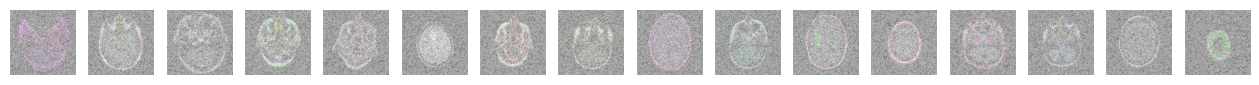

In [ ]:
pred = (nn.Sigmoid()(pred)>0.5).double()
preds = [pred]
preds = torch.mean(torch.stack(preds, dim=0), dim=0).cpu().detach()
imgs  = imgs.cpu().detach()
plot_img_and_mask(imgs,preds)

In [ ]:
import torch.cuda.amp as amp # GPU接続時にモデルのトレーニングを高速化

In [ ]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    scaler = amp.GradScaler()

    dataset_size = 0
    running_loss = 0.0

    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Train ')
    for step, (images, masks) in pbar:
        images = images.to(device, dtype=torch.float)
        masks  = masks.to(device, dtype=torch.float)

        batch_size = images.size(0)
        # print("動いています.")
        with amp.autocast(enabled=True):
            y_pred = model(masks,images)

            loss   = criterion(y_pred, masks)
            loss   = loss / CFG.n_accumulate
            # print("計算できました.")

        scaler.scale(loss).backward()

        if (step + 1) % CFG.n_accumulate == 0:
            scaler.step(optimizer)
            scaler.update()

            # 勾配の初期化
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()

        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size

        epoch_loss = running_loss / dataset_size

        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(train_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_mem=f'{mem:0.2f} GB')
    torch.cuda.empty_cache()
    gc.collect()

    return epoch_loss

In [ ]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()

    dataset_size = 0
    running_loss = 0.0

    val_scores = []

    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Valid ')
    for step, (images, masks) in pbar:
        images  = images.to(device, dtype=torch.float)
        masks   = masks.to(device, dtype=torch.float)

        batch_size = images.size(0)

        y_pred  = model(masks,images)
        loss    = criterion(y_pred, masks)

        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size

        epoch_loss = running_loss / dataset_size

        y_pred = nn.Sigmoid()(y_pred)
        val_dice = dice_coef(masks, y_pred).cpu().detach().numpy()
        val_jaccard = iou_coef(masks, y_pred).cpu().detach().numpy()
        val_scores.append([val_dice, val_jaccard])

        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(valid_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_memory=f'{mem:0.2f} GB')
    val_scores  = np.mean(val_scores, axis=0)
    torch.cuda.empty_cache()
    gc.collect()

    return epoch_loss, val_scores

In [ ]:
!pip install colorama

from colorama import Fore, Back, Style
c_  = Fore.GREEN
sr_ = Style.RESET_ALL
from collections import defaultdict

In [ ]:
def run_training(model, optimizer, scheduler, device, num_epochs):
    if torch.cuda.is_available():
        print("cuda: {}\n".format(torch.cuda.get_device_name()))

    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_dice      = -np.inf
    best_epoch     = -1
    history = defaultdict(list)

    for epoch in range(1, num_epochs + 1):
        gc.collect()
        print(f'Epoch {epoch}/{num_epochs}', end='')
        train_loss = train_one_epoch(model, optimizer, scheduler,
                                           dataloader=train_loader,
                                           device=CFG.device, epoch=epoch)
        val_loss, val_scores = valid_one_epoch(model, valid_loader,
                                                 device=CFG.device,
                                                 epoch=epoch)
        val_dice, val_jaccard = val_scores

        history['Train Loss'].append(train_loss)
        history['Valid Loss'].append(val_loss)
        history['Valid Dice'].append(val_dice)
        history['Valid Jaccard'].append(val_jaccard)


        print(f'Valid Dice: {val_dice:0.4f} | Valid Jaccard: {val_jaccard:0.4f}')

        if val_dice >= best_dice:
            print(f"{c_}Valid Score が更新されました ({best_dice:0.4f} ---> {val_dice:0.4f})")
            best_dice    = val_dice
            best_jaccard = val_jaccard
            best_epoch   = epoch

            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"best_epoch-{fold:02d}.bin"
            torch.save(model.state_dict(), PATH)
            print(f"Model Saved{sr_}")

        last_model_wts = copy.deepcopy(model.state_dict())
        PATH = f"last_epoch-{fold:02d}.bin"
        torch.save(model.state_dict(), PATH)

        print(); print()

    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Score: {:.4f}".format(best_jaccard))

    model.load_state_dict(best_model_wts)

    return model, history

In [ ]:
from torch.optim import lr_scheduler
def fetch_scheduler(optimizer):
    if CFG.scheduler == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CFG.T_max,
                                                   eta_min=CFG.min_lr)
    elif CFG.scheduler == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CFG.T_0,
                                                             eta_min=CFG.min_lr)
    elif CFG.scheduler == 'ReduceLROnPlateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,
                                                   mode='min',
                                                   factor=0.1,
                                                   patience=7,
                                                   threshold=0.0001,
                                                   min_lr=CFG.min_lr,)
    elif CFG.scheduer == 'ExponentialLR':
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.85)
    elif CFG.scheduler == None:
        return None

    return scheduler

In [ ]:
model = MedSegDiff(unet,timesteps=1000)
model = model.to(CFG.device)
optimizer = optim.Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.wd)
scheduler = fetch_scheduler(optimizer)

In [ ]:
import gc
gc.collect()

12

In [ ]:
y.shape

### **ここで実行してる**

In [ ]:
model, history = run_training(model, optimizer, scheduler,
                                  device=CFG.device,
                                  num_epochs=CFG.epochs)

cuda: Tesla T4

Epoch 1/30

Valid : 100%|██████████| 639/639 [12:48<00:00,  1.20s/it, gpu_memory=7.46 GB, lr=0.00200, valid_loss=22046.4016]


Valid Dice: 0.0197 | Valid Jaccard: 0.0104
Valid Score が更新されました (-inf ---> 0.0197)
Model Saved


Epoch 2/30

Train :   9%|▉         | 65/687 [00:59<09:25,  1.10it/s, gpu_mem=15.65 GB, lr=0.00200, train_loss=nan]


KeyboardInterrupt: 

### **サンプリング**

In [ ]:
diffuser = MedSegDiff(unet,timesteps=10)

img = torch.randn(1, 3, 256, 256)
cond_img = torch.randn(1, 3, 256, 256)
preds = diffuser.sample(img)
print(preds.shape)